In [ ]:
%%html
<style>
div.input {
    display:none;
}
</style>

In [65]:
%matplotlib inline

In [100]:
import warnings
import os
import pandas as pd
import numpy as np
from datetime import timedelta
from ggplot import *

from plotly.graph_objs import Bar, Scatter, Figure, Layout

import plotly.plotly as py
import plotly.graph_objs as go



warnings.filterwarnings('ignore')

##############################################################
# Let's load the data

# All Invoicing data (2013-01-01 - 2015-01-01) DTN Destination Travel Network
data = pd.read_csv('onsite_ad_analysis/all_advertisers_v2.csv')
# All bookingcom data (2015-01-01 - 2016-08-31) Bookings from our site
files = os.listdir('onsite_ad_analysis')
booking_files = [f for f in files if 'booking' in f]
booking_frames = []
for f in booking_files:
    directory = 'onsite_ad_analysis'
    path = os.path.join(directory, f) 
    temp = pd.read_csv(path)
    booking_frames.append(temp)

booking_data = pd.concat(booking_frames)


# Ad Performance data 
ad_data = pd.read_csv('onsite_ad_analysis/ad_performance.csv')



In [102]:
ad_data

,Ad Unit Performance Summary,Impressions,Clicks,CTR,Avg. Monthly Impressions,Avg. Monthly Clicks,Avg. Monthly CTR
0,Header,19,1,5.26%,1,0,5.26%
1,Mobile Banner,"3,401,372","11,754",0.35%,"261,644",904,0.35%
2,Page Sponsors,"178,424","1,530",0.86%,"13,725",118,0.86%
3,Homepage Sponsor,"250,836","4,761",1.90%,"19,295",366,1.90%
4,Featured Listing,"1,969,800","19,935",1.01%,"151,523","1,533",1.01%
5,ROS Banner,"2,818,636","3,486",0.12%,"216,818",268,0.12%
6,Text Links,"12,998,442","15,861",0.12%,"999,880","1,220",0.12%


In [ ]:
##############################################################
# Let's format the DTN data

data = data.rename(
        columns={
        "Desc" : "advertiser_name"
    })

# Format Dates
data['Date'] = pd.to_datetime(data['Month-Year'])
data['Date'] = data['Date']



# Clean Descriptions (member names)
data['advertiser_name'] = data['advertiser_name'].str.replace(' - Monterey','')

data['advertiser_name'] = data['advertiser_name'].str.replace(' - April','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - May','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - June','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - July','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - August','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - September','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - October','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - November','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - December','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - January','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - February','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' - March','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -April','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -May','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -June','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -July','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -August','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -September','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -October','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -November','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -December','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -January','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -February','')
data['advertiser_name'] = data['advertiser_name'].str.replace(' -March','')

# Format new column for month-year. Readability

data['Month-Year'] = data['Date'].apply(lambda x: str(x.month) + "-" + str(x.year))
data['Month'] = data['Date'].apply(lambda x: x.month)
data['Year']  = data['Date'].apply(lambda x: x.year)
data['Amount'] = data['Amount'].str.replace(' ', '')
data['Amount'] = data['Amount'].str.replace(',', '')
data['Amount'] = data['Amount'].apply(float)

In [ ]:
##############################################################
# Let's format the Booking data

#Rename Columns
booking_data = booking_data.rename(
        columns={
        "book nr." : "book_nr",
        "booked"  : "booked",
        "arrival" : "arrival",
        "departure" : "departure",
        "comission_eur" : "comission_eur",
        "perc" : "fee_eur",
        "total transaction value ( EUR )" : "total_trans_value_eur",
        "slip nr." : "slip_nr",
        "affiliate id" : "affiliate_id",
        "hotel name" : "hotel_name",
        "accomodation type" : "accomodation_type",
        "hotel city" : "hotel_city",
        "hotel ufi" : "hotel_ufi"
    })


#Subset Columns needed
booking_data_v2 = booking_data[['booked',
                                'arrival',
                                'departure',
                                'total_trans_value_eur',
                                'hotel_name',
                                'hotel_city',
                                'accomodation_type']]


booking_data_v2['booked'] = pd.to_datetime(booking_data_v2['booked'])
booking_data_v2['arrival'] = pd.to_datetime(booking_data_v2['arrival'])
booking_data_v2['departure'] = pd.to_datetime(booking_data_v2['departure'])

data_v1 = data[data['Date'] < '2016-08-31']
data_v1 = data_v1[['advertiser_name','Amount','Month-Year','Month','Year','Date']]



In [107]:
##############################################################
# Let's transform the DTN data for visualization & modeling

## Top Spenders
ts = data_v1.groupby(['advertiser_name','Year'])
ts = ts['Amount'].sum()
ts = ts.reset_index()
ts = ts.sort(['Year','Amount'], ascending = False)
grouped = ts.groupby('Year')['Amount'].nlargest(3)
ts = ts.reset_index()
grouped_v2 = grouped.reset_index()
index = grouped_v2['level_1']
ts_v2 = ts[ts['index'].isin(index)]
ts_v3 = ts_v2[['advertiser_name', 'Year', 'Amount']]
ts_v3 = ts_v3.rename(columns={'advertiser_name': 'Member', 'Amount':'Spent'})
ts_v3

## Average Participating Member Contract Length Over Time
ct = data_v1.groupby(['Year'])
ct = ct['Month'].aggregate(len)
ct = ct.reset_index()
ct_v2 = ct.groupby(['Year'])['Month'].aggregate(np.mean)
ct_v2 = ct_v2.reset_index()
ct_v2['Year'] = ct_v2['Year'].apply(str)

## Revenue by Year
yr_revenue = data_v1.groupby(['Year'])['Amount'].aggregate(sum)
yr_revenue = yr_revenue.reset_index()
yr_revenue['Year'] = pd.to_datetime(yr_revenue['Year'], format = '%Y')
#yr_revenue['Year'] = yr_revenue['Year'].apply(lambda x: x.year)
yr_revenue['Amount'] = yr_revenue['Amount'].apply(int)

# Revenue Over Month
revenue = data_v1.groupby(['Month-Year'])#.aggregate(sum)
revenue = revenue[['Amount']].aggregate(sum)
revenue = revenue.reset_index()
revenue['Month-Year'] = pd.to_datetime(revenue['Month-Year'])
revenue = revenue.sort('Month-Year')

# So far we haven't touched the Gross Amounts. We know need to account for the fact that the 
# CVB only gets 40% of the Gross Amount. 
revenue['MCCVB Amount'] = revenue['Amount']*.4

#Cumulative Revenue
revenue['Cumulative Revenue'] = revenue['Amount'].cumsum()
revenue['Cumulative MCCVB Revenue'] = revenue['MCCVB Amount'].cumsum()
revenue['Date'] = pd.to_datetime(revenue['Month-Year'])


# Revenue by year

unique_data = data_v1.drop_duplicates('advertiser_name')
# Unique Participants over Time
users = data_v1.groupby(['Date','advertiser_name']).aggregate(len)
users = users.reset_index()
# Aggregate Monthly
users_v2 = users.groupby(['Date']).aggregate(len)
users_v2 = users_v2.reset_index()
users_v2 = users_v2[['Date','Amount']]
users_v2 = users_v2.rename(columns={"Amount":"Unique Members"})
users_v2['Date'] = pd.to_datetime(users_v2['Date'])
users_v2['Month-Year'] = users_v2['Date'].apply(lambda x: str(x.month) + "-" + str(x.year))
users_v2['Month-Year'] = pd.to_datetime(users_v2['Month-Year'])
# Aggregate Yearly
users_year = unique_data.groupby(['advertiser_name','Year']).aggregate(len)
users_year = users_year.reset_index()
users_year_v2 = users_year.groupby(['Year']).aggregate(sum)
users_year_v2 = users_year_v2.reset_index()
users_year_v2 = users_year_v2.rename(columns={"Amount":"Unique Members"})


# Revenue and Participants over Time
full_u_r = pd.merge(users_v2, revenue, on = ['Date','Month-Year'])
full_u_r['Cost-Per-Member'] = full_u_r['Amount']/full_u_r['Unique Members']

# Revenue and Participants Yearly
full_u_r_v2 = full_u_r
full_u_r_v2['Date'] = pd.to_datetime(full_u_r_v2['Date'])
full_u_r_v2['Year'] = users_v2['Date'].apply(lambda x: str(x.year))
full_u_r_v3 = full_u_r_v2.groupby(['Year']).aggregate(sum)
full_u_r_v3 = full_u_r_v3.reset_index()


# Retention Rates, Who stayed and who bailed



# Loyalty - Avg Contract Lengths



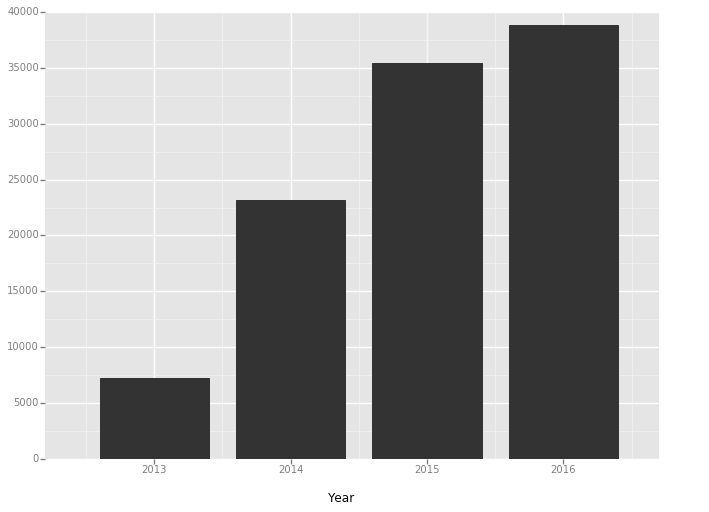

<ggplot: (20951030)>

In [122]:
##############################################################
# Let's visualize

#INSERT YEARLY BAR HERE #

## Yearly Plot
yr_plot_data = [
                go.Bar(
                x = yr_revenue['Year'],
                y = yr_revenue['Amount'])
]
#py.iplot(yr_cm_data, filename='nm-contracts-chart')


## Contract Months
yr_cm_data = [
                go.Scatter(
                x = ct_v2['Year'],
                y = ct_v2['Month'])
]

#py.iplot(yr_cm_data, filename='nm-contracts-chart')


rev_yr = ggplot(aes(x="Year",weight="Amount"), data = yr_revenue)
rev_yr = rev_yr + geom_bar() + scale_x_discrete(labels = ['2013','2014','2015','2016'])
rev_yr = rev_yr + scale_y_continuous(labels='comma')
rev_yr

#py.iplot(yr_plot_data, filename='bar-chart')



In [133]:
yr_revenue['Amount'].sum()

104692L

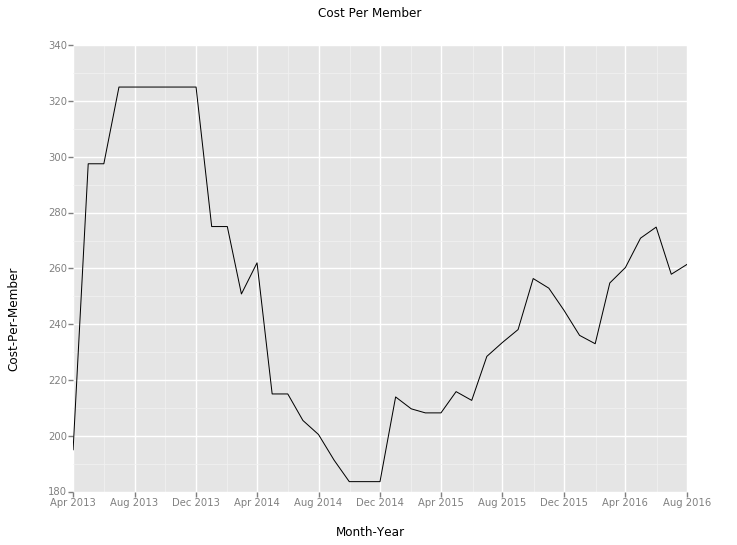

<ggplot: (17521636)>

In [72]:
# Cost Per Member
rev_cpm = ggplot(aes(x='Month-Year', y = 'Cost-Per-Member'), data = full_u_r)
rev_cpm = rev_cpm + geom_line() + ggtitle("Cost Per Member")
rev_cpm

In [79]:
# Table of Top 3 Spenders Per Year
ts_v3

,Member,Year,Spent
0,Portola Hotel & Spa,2016,5600.0
1,Monterey Zoo (Previously Wild Things),2016,3300.0
2,Monterey Peninsula Inn,2016,2700.0
32,Carmel Mission Inn,2015,6600.0
33,Monterey Zoo (Previously Wild Things),2015,3300.0
34,Hilton Garden Inn,2015,2250.0
58,Downtown Dining,2014,2840.0
59,Flaherty's Oyster Bar & Seafood Grill,2014,2750.0
60,Embassy Suites Monterey Bay-Seaside,2014,2280.0
75,Taste Morgan,2013,3200.0


In [132]:
# Cumulative Revenue from Operations
#rev_cumsum = ggplot(aes(x='Month-Year', y = 'Cumulative Revenue'), data = revenue)
#rev_cumsum = rev_cumsum + geom_line(stat = 'identity') + ggtitle("Cumulative Revenue")
#ct_v2.dtypes



# Unique Members
rev_um = ggplot(aes(x='Month-Year', y = 'Unique Members'), data = full_u_r)
rev_um = rev_um + geom_line() + ggtitle("Participation")
rev_um


# Number of contract months per year
#ct_v2_plot = ct_v2['Month'].plot(kind='bar', title = "Number of Contract Months Per Year")
cm_py = ggplot(aes(x = 'Year', weight='Month'), data = ct_v2)
cm_py = cm_py + geom_bar()
cm_py
ct_v2



,Year,Month
0,2013,23
1,2014,112
2,2015,157
3,2016,153


The steady increase in participation is an indication from the market for the value of the exposure and demand for those impressions.

In [125]:
data_v1['Amount'].sum()*.4

41876.8

In [ ]:
Onsite Advertising Analysis


Introduction
    -Briefly what we offer
    -What is being considered

Context
    -How much?
        -3 year spend breakout
        -cumulative sum? bar? timeseries?
    -Who?
        -Uniques
        -Top Spenders
    -Loyalty
        -Retention

Other DMOs



Pros & Cons  |  Best Practices   |   POV



Final Thoughts